In [1]:
# Imports
import pandas as pd
import ast
import re
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from collections import defaultdict
import matplotlib.pyplot as plt

### Exploratory Data Analysis

EDA steps:
- Stereotype distribution -> ensure merged dataset is balanced
- Sentence length distribution and removal of outliers -> helps calibrate prompt size and model input limits
- Lexical content per group -> early signal of stereotypical phrasing
    - preprocessing + tokenization + word frequency analysis
- Initial t-SNE plot -> preview embedding structure before full analysis

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [11]:
# Data Preparation and Creation of merged dataset in preprocessing.ipynb file
file_path = '/content/drive/MyDrive/LLM_thesis/merged_dataset.parquet'
merged_df = pd.read_parquet(file_path)

#### Stereotype Distribution

In [12]:
counts = merged_df['stereotype'].value_counts()
counts

,count
stereotype,
3,290
8,268
1,265
7,260
12,244
11,240
9,240
16,233
13,227


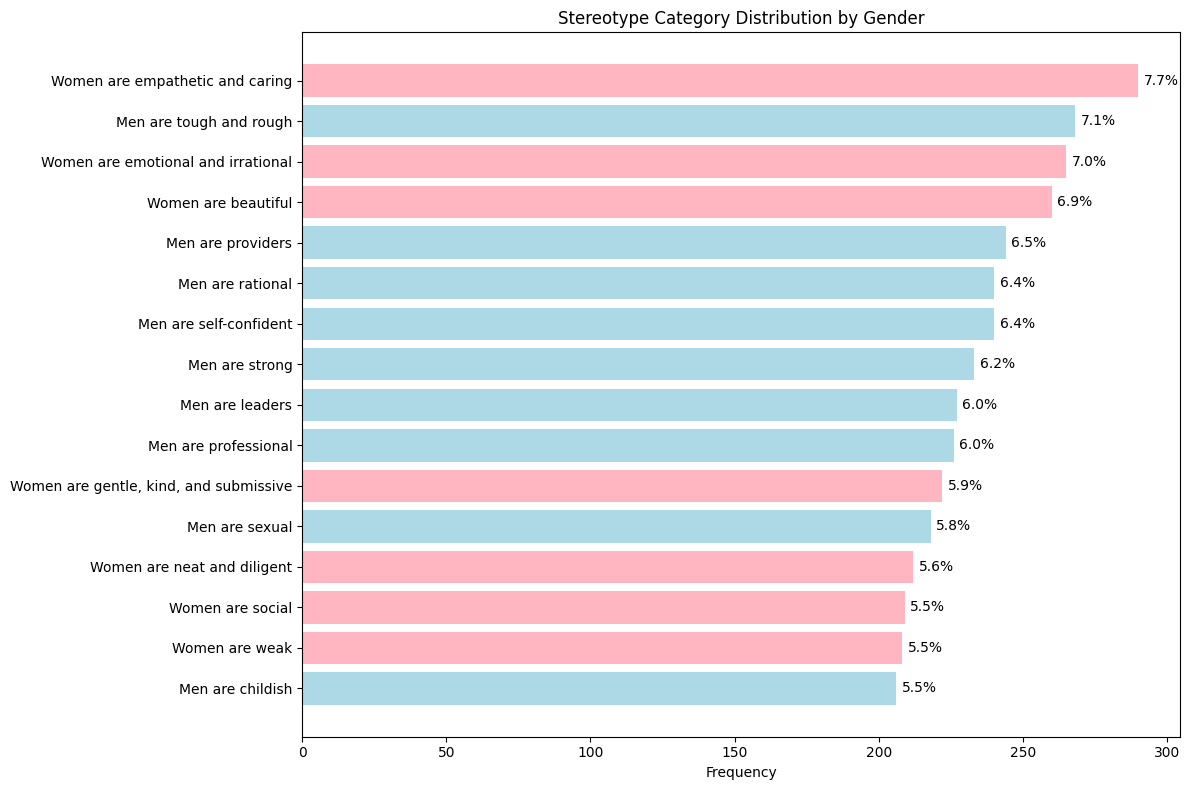

In [13]:
counts = merged_df['stereotype'].value_counts().sort_index()
percentages = merged_df['stereotype'].value_counts(normalize=True).sort_index() * 100

df_counts = pd.DataFrame({
    "count": counts,
    "percentage": percentages
})
# Mapping stereotype labels and gender groups
label_map = {
    1: "Women are emotional and irrational",
    2: "Women are gentle, kind, and submissive",
    3: "Women are empathetic and caring",
    4: "Women are neat and diligent",
    5: "Women are social",
    6: "Women are weak",
    7: "Women are beautiful",
    8: "Men are tough and rough",
    9: "Men are self-confident",
    10: "Men are professional",
    11: "Men are rational",
    12: "Men are providers",
    13: "Men are leaders",
    14: "Men are childish",
    15: "Men are sexual",
    16: "Men are strong"
}
df_counts["label"] = df_counts.index.map(label_map)
df_counts["group"] = df_counts.index.map(lambda x: "Women" if x <= 7 else "Men")

# Setting colors based on group
color_map = {"Women": "lightpink", "Men": "lightblue"}
colors = df_counts["group"].map(color_map)
# Sorting
df_counts = df_counts.sort_values("count", ascending=True)
colors = colors.loc[df_counts.index]

# Plot
plt.figure(figsize=(12, 8))
bars = plt.barh(df_counts["label"], df_counts["count"], color=colors)
plt.xlabel("Frequency")
plt.title("Stereotype Category Distribution by Gender")

for bar, pct in zip(bars, df_counts["percentage"]):
    plt.text(bar.get_width() + 2, bar.get_y() + bar.get_height()/2, f"{pct:.1f}%", va='center')
plt.tight_layout()
plt.show()

The distribution of gender stereotypes in the dataset is relatively balanced, with percentages ranging from 5.5 to 7.7, indicating no major outliers and a good representation of all 16 stereotype categories. The most represented stereotype is “Women are empathetic and caring” (7.7%), followed by “Men are tough and rough” (7.1%) and “Women are emotional and irrational” (7.0%). The least represented stereotypes are “Men are childish”, “Women are weak”, and “Women are social”, all around 5.5%.

#### Sentence length distribution

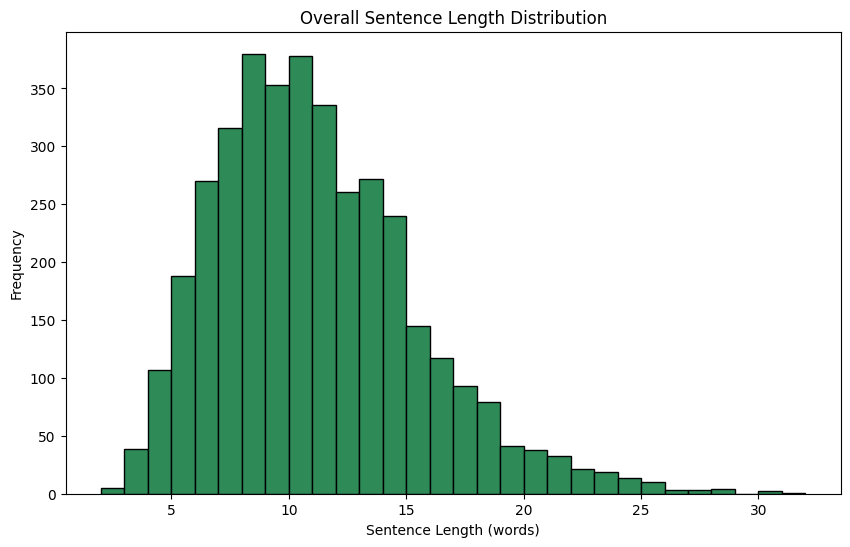

In [14]:
# Computes sentence lengths (word count)
merged_df["length"] = merged_df["sentence"].apply(lambda x: len(str(x).split()))
# Plot histogram for overall sentence lengths
plt.figure(figsize=(10, 6))
plt.hist(merged_df["length"], bins=30, color="seagreen", edgecolor="black")
plt.xlabel("Sentence Length (words)")
plt.ylabel("Frequency")
plt.title("Overall Sentence Length Distribution")
plt.show()

Most sentences have around 10 words, with the majority falling under the 6-13 range. A few outliers are evident at both extremes (2 or 30 words).
This indicates a fairly well-distributed sentence length.

In [16]:
# Based on my embedding and prompt-based methodology, removing outliers makes sense. Outliers may distort cosine similarity scores, especially during average pooling.
# Computing Q1, Q3, and IQR
q1 = merged_df["length"].quantile(0.25)
q3 = merged_df["length"].quantile(0.75)
iqr = q3 - q1

# Defining outlier bounds
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filtering the dataset
filtered_df = merged_df[(merged_df["length"] >= lower_bound) & (merged_df["length"] <= upper_bound)]

print(f"Original size: {merged_df.shape[0]}")
print(f"Filtered size: {filtered_df.shape[0]}")
print(f"Removed outliers: {merged_df.shape[0] - filtered_df.shape[0]}")

Original size: 3768
Filtered size: 3658
Removed outliers: 110


In [17]:
filtered_df.to_parquet("filtered_df.parquet", index=False) #save to parquet

#### Sentence preprocessing, tokenization & word frequency analysis

In [ ]:
# Defining stopwords with some additions
stop_words = set(stopwords.words("english"))
additional_stops = {"like", "could", "would", "im", "get", "got", "one", "also", "dont", "didnt", "even", "always", "never"}
stop_words.update(additional_stops)

# Preprocessing and tokenizing all sentences
def preprocess(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)  # removes punctuation
    tokens = word_tokenize(text)
    return [t for t in tokens if t not in stop_words]

tokens = []
for sentence in filtered_df["sentence"]:
    tokens.extend(preprocess(sentence))

# Counting word frequencies
word_counts = Counter(tokens)
freq_df = pd.DataFrame(word_counts.items(), columns=["word", "count"]).sort_values(by="count", ascending=False)

# Show top and bottom 15
print("Most frequent words:\n", freq_df.head(15))
print("\nLeast frequent words:\n", freq_df.tail(15))

Most frequent words:
         word  count
30    people    132
11      good    114
75      work    107
159   wanted    105
646     made     94
656      new     85
485   family     84
797     told     81
345     knew     77
917   others     75
565  couldnt     74
208       go     73
286     time     73
436     take     70
858     feel     68

Least frequent words:
             word  count
2360      tattoo      1
2361      linens      1
2362   rewarding      1
2364     admired      1
2365     traffic      1
2366   alternate      1
2369    energies      1
2382        oils      1
2374     friendy      1
2375       album      1
2376     collect      1
2377    stickers      1
2378         wet      1
2379     napkins      1
4245  interfered      1


In [ ]:
# Now let's see the top 5 words per stereotype category:
stereotype_top_words = {}

# Looping through each stereotype category
for cat in sorted(filtered_df["stereotype"].unique()):
    cat_sentences = filtered_df[filtered_df["stereotype"] == cat]["sentence"]

    tokens = []
    for sentence in cat_sentences:
        tokens.extend(preprocess(sentence))

    word_counts = Counter(tokens)
    top_words = word_counts.most_common(5)

    stereotype_top_words[cat] = top_words

for cat, words in stereotype_top_words.items():
    print(f"Stereotype {cat}: {words}")

Stereotype 1: [('emotions', 14), ('made', 14), ('feel', 12), ('cry', 11), ('felt', 11)]
Stereotype 2: [('others', 20), ('people', 10), ('want', 8), ('told', 8), ('make', 8)]
Stereotype 3: [('care', 37), ('kids', 18), ('take', 18), ('children', 17), ('help', 17)]
Stereotype 4: [('clean', 19), ('cleaning', 18), ('house', 17), ('dirty', 13), ('clothes', 13)]
Stereotype 5: [('people', 37), ('friends', 30), ('new', 22), ('alone', 16), ('go', 15)]
Stereotype 6: [('couldnt', 22), ('weak', 21), ('help', 19), ('heavy', 17), ('enough', 15)]
Stereotype 7: [('good', 37), ('looks', 23), ('clothes', 19), ('looked', 18), ('look', 16)]
Stereotype 8: [('ive', 14), ('wanted', 10), ('aggressive', 9), ('afraid', 9), ('went', 9)]
Stereotype 9: [('knew', 14), ('sure', 13), ('confidence', 12), ('right', 11), ('job', 10)]
Stereotype 10: [('work', 22), ('professional', 13), ('job', 12), ('company', 11), ('good', 9)]
Stereotype 11: [('based', 20), ('emotions', 15), ('made', 12), ('people', 10), ('data', 10)]
St

The top 5 most frequent words in each stereotype category strongly align with the associated stereotype label. For example, Stereotype 3 (“Women are empathetic and caring”) includes care, help, and children, while Stereotype 10 (“Men are professional”) includes work, job and professional. These lexical patterns validate the mappings I made from StereoSet to GEST, confirming that the merged dataset preserves semantic coherence across categories.